In [79]:
# Code taken from https://colab.research.google.com/drive/156E53b0BNAdATgPsr8GfSkW59lkx3QZh#scrollTo=EAaX08ocQ94Z
import argparse
import datetime
import os
import random
import time
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.profilers import SimpleProfiler
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd

## Define Architecture

In [80]:
class Linear(pl.LightningModule):
    # https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html
    def __init__(self, **kwargs):
        super().__init__()
        self.lr = kwargs.get('lr')

        self.l1 = nn.Linear(28 * 28, 128)
        self.l2 = nn.Linear(128, 10)

        self.save_hyperparameters()

    def forward(self, x):
        # defines model(...) function
        x = x.view(x.size(0), -1)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('Training loss', loss.item())
        return loss

    def on_validation_start(self):
        self.losses = []
        self.accuracies = []

    def validation_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = F.cross_entropy(probs, y)

        acc = self.accuracy(probs, y)
        self.accuracies.extend(acc.cpu().numpy().tolist())
        self.losses.append(loss.item())
        return loss

    def validation_epoch_end(self, outputs):
        overall_acc = np.mean(self.accuracies)
        overall_loss = np.mean(self.losses)
        self.log('Validation loss', overall_loss)
        self.log('Validation Accuracy', overall_acc)

    def on_test_start(self):
        self.accuracies = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = self.accuracy(logits, y)
        self.accuracies.extend(acc.cpu().numpy().tolist())
        return acc

    def test_epoch_end(self, outputs):
        overall_acc = np.mean(self.accuracies)
        self.log("Test Accuracy", overall_acc)

    def accuracy(self, logits, y):
        acc = torch.eq(torch.argmax(logits, -1), y).to(torch.float32)
        return acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [81]:
class Conv(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.lr = kwargs.get('lr')

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.out = nn.Linear(32 * 7 * 7, 10)

        self.save_hyperparameters()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('Training loss', loss.item())
        return loss
        # TODO: If you have time also log the train accuracy

    def on_validation_start(self):
        self.losses = []
        self.accuracies = []

    def validation_step(self, batch, batch_idx):
        x, y = batch
        probs = self(x)
        loss = F.cross_entropy(probs, y)

        acc = self.accuracy(probs, y)
        self.accuracies.extend(acc.cpu().numpy().tolist())
        self.losses.append(loss.item())
        return loss

    def validation_epoch_end(self, outputs):
        overall_acc = np.mean(self.accuracies)
        overall_loss = np.mean(self.losses)
        self.log('Validation loss', overall_loss)
        self.log('Validation Accuracy', overall_acc)

    def on_test_start(self):
        self.accuracies = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = self.accuracy(logits, y)
        self.accuracies.extend(acc.cpu().numpy().tolist())
        return acc

    def test_epoch_end(self, outputs):
        overall_acc = np.mean(self.accuracies)
        self.log("Test Accuracy", overall_acc)

    def accuracy(self, logits, y):
        acc = torch.eq(torch.argmax(logits, -1), y).to(torch.float32)
        return acc

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Define DataModule

In [82]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, **kwargs):
        # https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html
        super().__init__()

        self.data_dir = kwargs.get('data_dir')
        self.batch_size = kwargs.get('batch_size')
        self.num_workers = kwargs.get('num_workers', 0)
        self.val_ratio = kwargs.get('val_ratio')

        error_msg = "[!] valid_size should be in the range [0, 1]."
        assert ((self.val_ratio >= 0) and (self.val_ratio <= 1)), error_msg

    # def prepare_data(self):
        # Downloading and saving data with multiple processes
        # (distributed settings) will result in corrupted data. Lightning ensures
        # the prepare_data() is called only within a single process on CPU, so you
        # can safely add your downloading logic within.
        datasets.MNIST(root=self.data_dir, train=True, download=True)
        datasets.MNIST(root=self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        # Assign train/val datasets for use in dataloaders

        # Data: data transformation strategy
        self.do_transform = transforms.Compose([transforms.RandomAffine(15, (0.1, 0.1), (0.95, 1.05)), transforms.ToTensor()])
        self.no_transform = transforms.Compose([transforms.ToTensor()])

        self.dataset_train = datasets.MNIST(root=self.data_dir, train=True, transform=self.do_transform)
        self.dataset_val = datasets.MNIST(root=self.data_dir, train=True, transform=self.no_transform)
        # print(type(self.dataset_train))
        # self.dataset_train = pd.read_csv('digit-recognizer/train.csv')[:25200] # remove label?
        # self.dataset_val = pd.read_csv('digit-recognizer/train.csv')[25200:] # remove label?

        num_train = len(self.dataset_train)
        indices = list(range(num_train))
        split = int(np.floor(self.val_ratio * num_train))

        np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        self.dataset_tr_indices = SubsetRandomSampler(train_idx)
        self.dataset_val_indices = SubsetRandomSampler(valid_idx)

        self.dataset_test = datasets.MNIST(root=self.data_dir, train=False, transform=self.no_transform)
        # self.dataset_test = pd.read_csv('digit-recognizer/test.csv')

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, sampler=self.dataset_tr_indices, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, sampler=self.dataset_val_indices, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)


In [ ]:
# have to normalize numbers between 0 - 1?

In [195]:
train = pd.read_csv('digit-recognizer/train.csv')
train_features = train[:25200].copy()
train_labels = train_features.pop('label')
train_features = train_features.values.reshape(25200, 1, 28, 28)
train_labels = train_labels.values.reshape(25200, 1)

In [196]:
train_labels

array([[1],
       [0],
       [1],
       ...,
       [7],
       [7],
       [3]])

In [180]:
zipped = zip(train_features, train_labels)

In [181]:
list(zipped)[0]

(array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0, 188, 255,  94,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0, 191, 250, 253,  93,   0,
     

In [186]:
temp = torch.from_numpy(train_features)

In [197]:
temp_labels = torch.tensor(train_labels)

In [202]:
temp_labels.shape

torch.Size([25200, 1])

In [192]:
print(type(temp[0]))
temp.shape

<class 'torch.Tensor'>


torch.Size([25200, 1, 28, 28])

In [86]:
train_labels.shape

(25200, 1)

In [203]:
torch.stack((temp, temp_labels))

RuntimeError: stack expects each tensor to be equal size, but got [25200, 1, 28, 28] at entry 0 and [25200, 1] at entry 1

In [87]:
pd.read_csv('digit-recognizer/test.csv')

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define Training Configuration

In [88]:
dict_args = {
    'model': Conv,
    'dataloader': MNISTDataModule,
    'load': None,
    'resume_from_checkpoint': None,
    'data_dir': './',
    'batch_size': 32,
    'epoch': 10,
    'num_workers': 0,
    'val_freq': 0.5,
    'logdir': './logs',
    'lr': 0.001,
    'display_freq': 64,
    'seed': 42,
    'clip_grad_norm': 0,
    'val_ratio': 0.2
}

In [89]:
# https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html
# Define seed for reproducibility everywhere!
pl.seed_everything(dict_args['seed'])
# Initialize model to train

if dict_args['load'] is not None:
    model = dict_args['model'].load_from_checkpoint(dict_args['load'], **dict_args)
else:
    model = dict_args['model'](**dict_args)

# Initialize logging paths
now = datetime.datetime.now().strftime('%m%d%H%M%S')
weight_save_dir = os.path.join(dict_args["logdir"], os.path.join('models', 'state_dict', now))

os.makedirs(weight_save_dir, exist_ok=True)

# Callback: model checkpoint strategy
checkpoint_callback = ModelCheckpoint(
    dirpath=weight_save_dir, save_top_k=5, verbose=True, monitor="Validation loss", mode="min"
)

#  TODO: Implement early stopping based on validation loss or accuracy

# Data: load data module
data_module = dict_args['dataloader'](**dict_args)

# Trainer: initialize training behaviour

logger = TensorBoardLogger(save_dir=dict_args['logdir'], version=now, name='lightning_logs', log_graph=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    val_check_interval=dict_args['val_freq'],
    deterministic=True,
    logger=logger,
    max_epochs=dict_args["epoch"],
    log_every_n_steps=dict_args["display_freq"],
    gradient_clip_val=dict_args['clip_grad_norm'],
    resume_from_checkpoint=dict_args['resume_from_checkpoint']
)

Global seed set to 42


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Train the model

In [90]:
trainer.fit(model, data_module)


  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 416   
1 | conv2 | Sequential | 12.8 K
2 | out   | Linear     | 15.7 K
-------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)
/Users/kprazuch/Documents/GitHub/MSCI546/.venv/lib/python3.12/site-packages/pytorch_lightning/loggers/tensorboard.py:246: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  rank_zero_warn(


/Users/kprazuch/Documents/GitHub/MSCI546/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/kprazuch/Documents/GitHub/MSCI546/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  50%|█████     | 1125/2250 [00:25<00:25, 44.00it/s, loss=0.239, v_num=0356]

Epoch 0, global step 750: 'Validation loss' reached 0.20201 (best 0.20201), saving model to './logs/models/state_dict/0308230356/epoch=0-step=750.ckpt' as top 5


Epoch 0: 100%|██████████| 2250/2250 [00:50<00:00, 44.25it/s, loss=0.164, v_num=0356] 

Epoch 0, global step 1500: 'Validation loss' reached 0.14374 (best 0.14374), saving model to './logs/models/state_dict/0308230356/epoch=0-step=1500.ckpt' as top 5


Epoch 1:  50%|█████     | 1125/2250 [00:24<00:24, 46.38it/s, loss=0.0938, v_num=0356]

Epoch 1, global step 2250: 'Validation loss' reached 0.11801 (best 0.11801), saving model to './logs/models/state_dict/0308230356/epoch=1-step=2250.ckpt' as top 5


Epoch 1: 100%|██████████| 2250/2250 [00:48<00:00, 46.05it/s, loss=0.117, v_num=0356] 

Epoch 1, global step 3000: 'Validation loss' reached 0.09874 (best 0.09874), saving model to './logs/models/state_dict/0308230356/epoch=1-step=3000.ckpt' as top 5


Epoch 2:  50%|█████     | 1125/2250 [00:24<00:24, 45.06it/s, loss=0.0996, v_num=0356]

Epoch 2, global step 3750: 'Validation loss' reached 0.08991 (best 0.08991), saving model to './logs/models/state_dict/0308230356/epoch=2-step=3750.ckpt' as top 5


Epoch 2: 100%|██████████| 2250/2250 [00:50<00:00, 44.80it/s, loss=0.114, v_num=0356] 

Epoch 2, global step 4500: 'Validation loss' reached 0.07681 (best 0.07681), saving model to './logs/models/state_dict/0308230356/epoch=2-step=4500.ckpt' as top 5


Epoch 3:  50%|█████     | 1125/2250 [00:25<00:25, 44.53it/s, loss=0.123, v_num=0356]

Epoch 3, global step 5250: 'Validation loss' reached 0.08652 (best 0.07681), saving model to './logs/models/state_dict/0308230356/epoch=3-step=5250.ckpt' as top 5


Epoch 3: 100%|██████████| 2250/2250 [00:50<00:00, 44.69it/s, loss=0.074, v_num=0356] 

Epoch 3, global step 6000: 'Validation loss' reached 0.07507 (best 0.07507), saving model to './logs/models/state_dict/0308230356/epoch=3-step=6000.ckpt' as top 5


Epoch 4:  50%|█████     | 1125/2250 [00:25<00:25, 44.31it/s, loss=0.0469, v_num=0356]

Epoch 4, global step 6750: 'Validation loss' reached 0.06964 (best 0.06964), saving model to './logs/models/state_dict/0308230356/epoch=4-step=6750.ckpt' as top 5


Epoch 4: 100%|██████████| 2250/2250 [00:50<00:00, 44.62it/s, loss=0.0524, v_num=0356]

Epoch 4, global step 7500: 'Validation loss' reached 0.06440 (best 0.06440), saving model to './logs/models/state_dict/0308230356/epoch=4-step=7500.ckpt' as top 5


Epoch 5:  50%|█████     | 1125/2250 [00:25<00:25, 44.02it/s, loss=0.0416, v_num=0356]

Epoch 5, global step 8250: 'Validation loss' reached 0.06288 (best 0.06288), saving model to './logs/models/state_dict/0308230356/epoch=5-step=8250.ckpt' as top 5


Epoch 5: 100%|██████████| 2250/2250 [00:52<00:00, 42.69it/s, loss=0.0676, v_num=0356]

Epoch 5, global step 9000: 'Validation loss' reached 0.07300 (best 0.06288), saving model to './logs/models/state_dict/0308230356/epoch=5-step=9000.ckpt' as top 5


Epoch 6:  50%|█████     | 1125/2250 [00:25<00:25, 44.72it/s, loss=0.053, v_num=0356] 

Epoch 6, global step 9750: 'Validation loss' reached 0.06115 (best 0.06115), saving model to './logs/models/state_dict/0308230356/epoch=6-step=9750.ckpt' as top 5


Epoch 6: 100%|██████████| 2250/2250 [00:51<00:00, 44.00it/s, loss=0.0875, v_num=0356]

Epoch 6, global step 10500: 'Validation loss' reached 0.05997 (best 0.05997), saving model to './logs/models/state_dict/0308230356/epoch=6-step=10500.ckpt' as top 5


Epoch 7:  50%|█████     | 1125/2250 [00:25<00:25, 44.03it/s, loss=0.0593, v_num=0356]

Epoch 7, global step 11250: 'Validation loss' reached 0.05248 (best 0.05248), saving model to './logs/models/state_dict/0308230356/epoch=7-step=11250.ckpt' as top 5


Epoch 7: 100%|██████████| 2250/2250 [00:50<00:00, 44.39it/s, loss=0.0442, v_num=0356]

Epoch 7, global step 12000: 'Validation loss' reached 0.05097 (best 0.05097), saving model to './logs/models/state_dict/0308230356/epoch=7-step=12000.ckpt' as top 5


Epoch 8:  50%|█████     | 1125/2250 [00:25<00:25, 44.18it/s, loss=0.0615, v_num=0356]

Epoch 8, global step 12750: 'Validation loss' was not in top 5


Epoch 8: 100%|██████████| 2250/2250 [00:50<00:00, 44.54it/s, loss=0.0407, v_num=0356]

Epoch 8, global step 13500: 'Validation loss' reached 0.05158 (best 0.05097), saving model to './logs/models/state_dict/0308230356/epoch=8-step=13500.ckpt' as top 5


Epoch 9:  50%|█████     | 1125/2250 [00:25<00:25, 43.45it/s, loss=0.0689, v_num=0356]

Epoch 9, global step 14250: 'Validation loss' reached 0.04895 (best 0.04895), saving model to './logs/models/state_dict/0308230356/epoch=9-step=14250.ckpt' as top 5


Epoch 9: 100%|██████████| 2250/2250 [00:51<00:00, 43.93it/s, loss=0.0321, v_num=0356]

Epoch 9, global step 15000: 'Validation loss' reached 0.05419 (best 0.04895), saving model to './logs/models/state_dict/0308230356/epoch=9-step=15000.ckpt' as top 5


Epoch 9: 100%|██████████| 2250/2250 [00:51<00:00, 43.93it/s, loss=0.0321, v_num=0356]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2250/2250 [00:51<00:00, 43.92it/s, loss=0.0321, v_num=0356]


## Test the model

In [91]:
trainer.test(model, ckpt_path='best', datamodule=data_module)

Restoring states from the checkpoint path at ./logs/models/state_dict/0308230356/epoch=9-step=14250.ckpt
Loaded model weights from checkpoint at ./logs/models/state_dict/0308230356/epoch=9-step=14250.ckpt
/Users/kprazuch/Documents/GitHub/MSCI546/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 313/313 [00:03<00:00, 92.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test Accuracy               0.9929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Test Accuracy': 0.9929}]

## Visualize Results

In [92]:
test_dataloader = data_module.test_dataloader()
wrong_preds_x = torch.empty(0, 1, 28, 28)
wrong_preds_y = torch.empty(0)
wrong_preds_label = torch.empty(0)
for batch in test_dataloader:
    x, y = batch
    pred = trainer.model(x)
    pred = torch.argmax(pred, dim=1)
    correct_mask = pred == y
    if torch.sum(correct_mask == False) >= 1:
        wrong_preds_x = torch.cat((wrong_preds_x, x[correct_mask == False]), dim=0)
        wrong_preds_y = torch.cat((wrong_preds_y, pred[correct_mask == False]), dim=0)
        wrong_preds_label = torch.cat((wrong_preds_label, y[correct_mask == False]), dim=0)
    if wrong_preds_y.size(0) >= 36:
        break

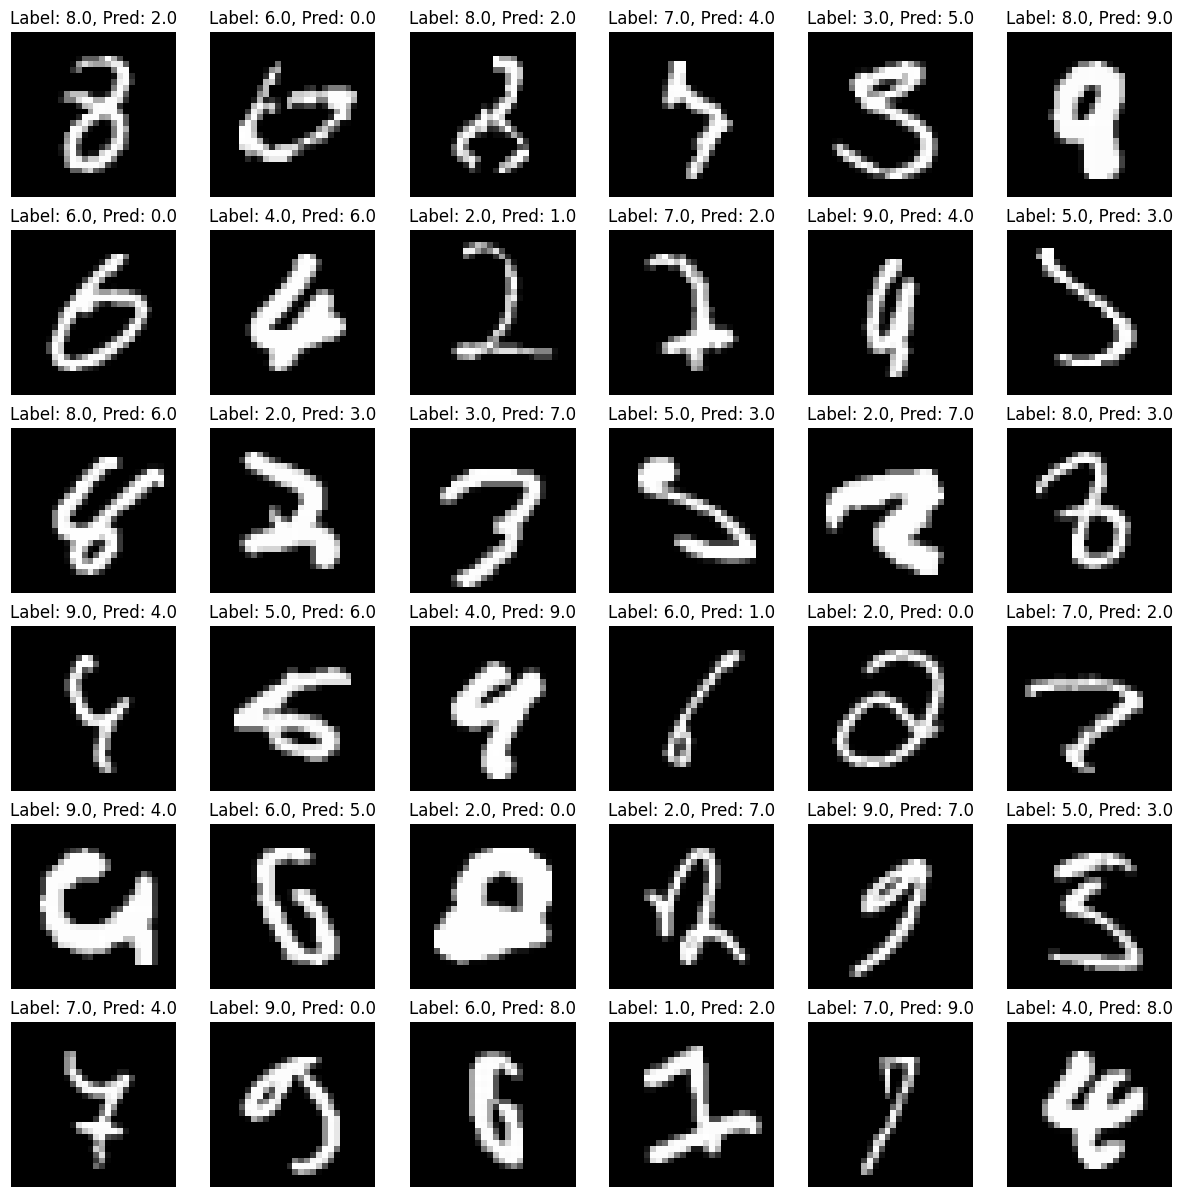

In [93]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for row in range(6):
    for col in range(6):
        ax[row, col].imshow(np.squeeze(wrong_preds_x[row*6+col].detach().cpu().numpy()), cmap='gray')
        ax[row, col].set_title(f'Label: {wrong_preds_label[row*6+col]}, Pred: {wrong_preds_y[row*6+col]}')
        ax[row, col].axis('off')

plt.show()

## My Work

In [185]:
print(type(data_module.dataset_train))
data_module.dataset_train[0]

<class 'torchvision.datasets.mnist.MNIST'>


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 